In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Successfully loaded data from Google Drive

Engineering features...
Handling missing values...
Encoding categorical variables...

Class distribution:
0    75.106970
1    19.632975
2     5.260055
Name: proportion, dtype: float64


<ipython-input-6-b87278964db1>:93: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill').fillna(method='bfill').fillna(X.mean())



Applying SMOTE...
Scaling features...

Building and compiling model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training model...
Epoch 1/100
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 79s 15ms/step - accuracy: 0.4222 - loss: 1.2108 - val_accuracy: 0.0000e+00 - val_loss: 1.5583 - learning_rate: 5.0000e-04
Epoch 2/100
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 74s 16ms/step - accuracy: 0.5108 - loss: 0.9948 - val_accuracy: 0.0000e+00 - val_loss: 1.5315 - learning_rate: 5.0000e-04
Epoch 3/100
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.5417 - loss: 0.9677 - val_accuracy: 0.0000e+00 - val_loss: 1.5482 - learning_rate: 5.0000e-04
Epoch 4/100
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 78s 15ms/step - accuracy: 0.5537 - loss: 0.9527 - val_accuracy: 0.0000e+00 - val_loss: 1.4886 - learning_rate: 5.0000e-04
Epoch 5/100
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - accuracy: 0.5628 - loss: 0.9399 - val_accuracy: 0.0000e+00 - val_loss: 1.5124 - learning_rate: 5.0000e-04
Epoch 6/100
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 85s 16ms/step - accuracy: 0.5714 - loss: 0.9317 - val_accuracy: 0.0000e+00 - val_loss: 1.4409 - learning_rate: 5.

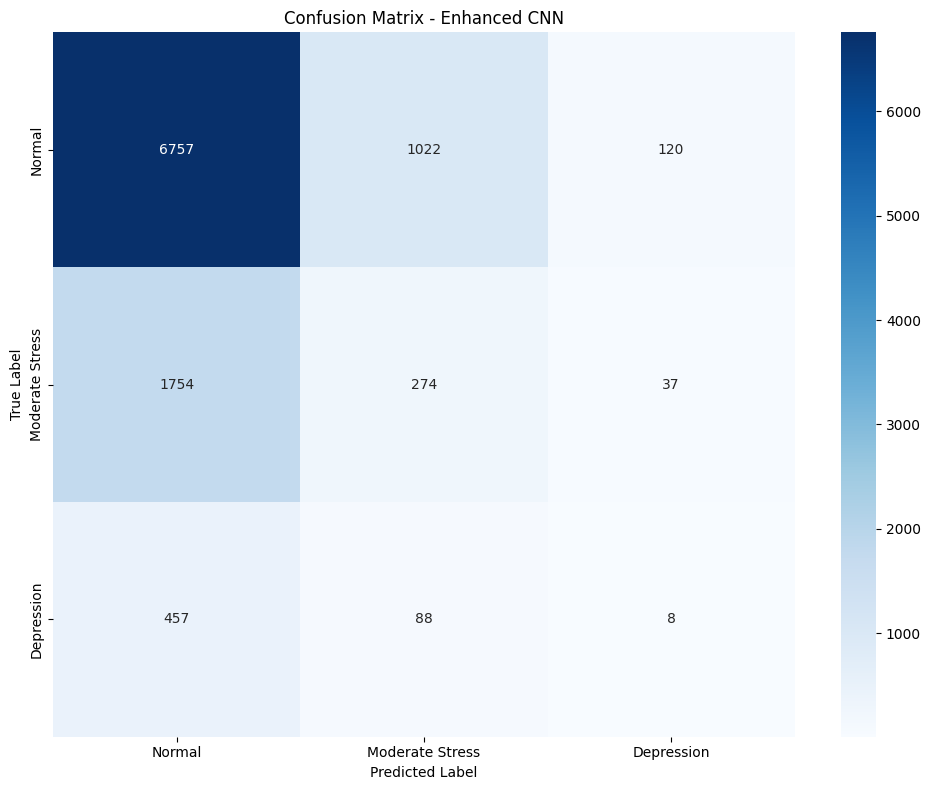

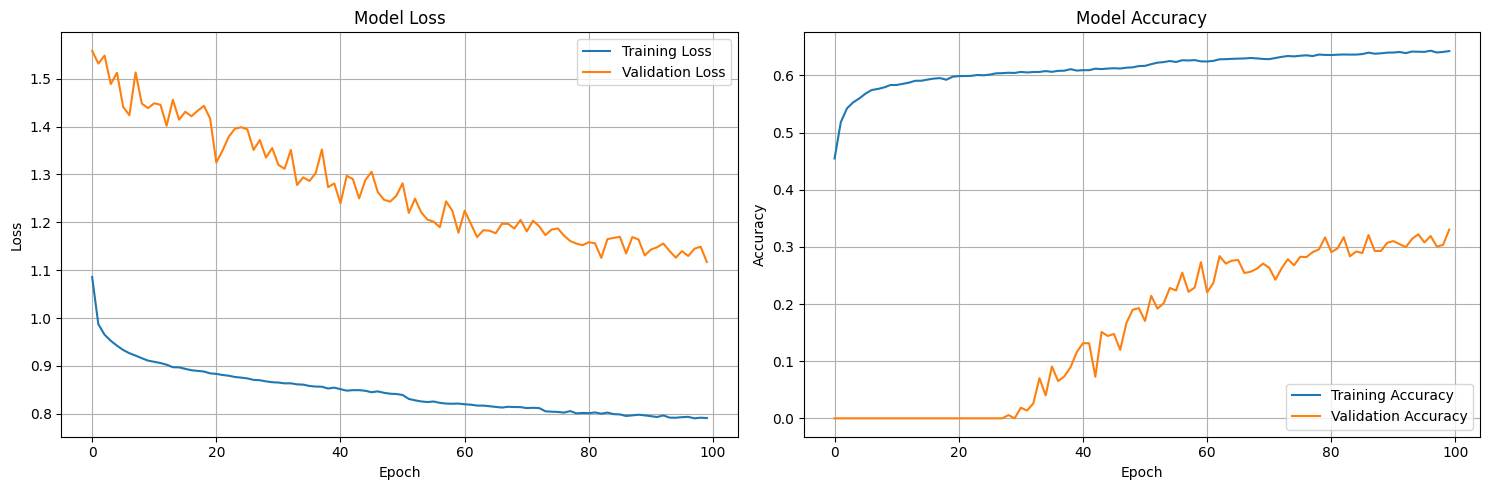


Model saved successfully

Training Summary:
Total epochs trained: 100
Best validation accuracy: 0.3303
Final training accuracy: 0.6427
Final validation accuracy: 0.3303


In [ ]:
!pip install imbalanced-learn tensorflow

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load data
try:
    cleaned_dataset_path = '/content/drive/My Drive/ML/new.csv'
    cleaned_data = pd.read_csv(cleaned_dataset_path)
    print("Successfully loaded data from Google Drive")
except:
    try:
        cleaned_data = pd.read_csv('new.csv')
        print("Successfully loaded data from local directory")
    except:
        print("Error: Could not load the dataset.")
        raise

# Define features and target
features = [
    'Heart_Rate',
    'Blood_Pressure_Systolic',
    'Blood_Pressure_Diastolic',
    'Skin_Temperature',
    'Respiration_Rate',
    'Sleep_Duration',
    'Activity_Levels',
    'Mood',
    'Stress_Level',
    'Resilience_Factors'
]
target = 'Mental_Health_Status'

def engineer_features(df):
    """Create domain-specific features"""
    result = df.copy()

    # Physiological Indices
    result['HR_Normalized'] = (df['Heart_Rate'] - 70) / 30
    result['BP_Index'] = (df['Blood_Pressure_Systolic'] / 120 + df['Blood_Pressure_Diastolic'] / 80) / 2
    result['Respiration_Normalized'] = (df['Respiration_Rate'] - 12) / 8

    # Health Scores
    result['Sleep_Quality'] = (df['Sleep_Duration'] * (10 - df['Stress_Level'])) / 10
    result['Mental_Wellness'] = (df['Mood'] + df['Resilience_Factors'] - df['Stress_Level']) / 3
    result['Physical_Activity'] = df['Activity_Levels'] * df['Sleep_Duration'] / 8

    # Stress and Recovery Metrics
    result['Stress_Recovery_Ratio'] = df['Resilience_Factors'] / df['Stress_Level'].replace(0, 1)
    result['Activity_Stress_Balance'] = df['Activity_Levels'] / df['Stress_Level'].replace(0, 1)

    # Combined Health Indicators
    result['Overall_Health_Score'] = (
        result['Mental_Wellness'] * 0.4 +
        result['Physical_Activity'] * 0.3 +
        result['Sleep_Quality'] * 0.3
    )

    # Add new features to features list
    global features
    new_features = [
        'HR_Normalized', 'BP_Index', 'Respiration_Normalized',
        'Sleep_Quality', 'Mental_Wellness', 'Physical_Activity',
        'Stress_Recovery_Ratio', 'Activity_Stress_Balance',
        'Overall_Health_Score'
    ]
    features.extend(new_features)

    return result

# Process and prepare data
print("\nEngineering features...")
cleaned_data = engineer_features(cleaned_data)
X = cleaned_data[features]
y = cleaned_data[target]

# Handle missing values
print("Handling missing values...")
X = X.fillna(method='ffill').fillna(method='bfill').fillna(X.mean())

# Encode categorical variables
print("Encoding categorical variables...")
categorical_columns = ['Mood', 'Stress_Level']
for col in categorical_columns:
    if X[col].dtype == 'object' or X[col].dtype.name == 'category':
        X[col] = LabelEncoder().fit_transform(X[col])

# Encode target variable
if y.dtype == 'object' or y.dtype.name == 'category':
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    class_names = label_encoder.inverse_transform([0, 1, 2])
else:
    y_encoded = y.astype(int).values
    class_names = ['Normal', 'Moderate Stress', 'Depression']

# Print class distribution
print("\nClass distribution:")
print(pd.Series(y_encoded).value_counts(normalize=True) * 100)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Apply SMOTE
print("\nApplying SMOTE...")
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Scale features
print("Scaling features...")
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Convert to categorical
num_classes = len(np.unique(y_encoded))
y_train_categorical = utils.to_categorical(y_train_res, num_classes=num_classes)
y_test_categorical = utils.to_categorical(y_test, num_classes=num_classes)

# Reshape data for CNN
X_train_reshaped = X_train_scaled[..., np.newaxis]
X_test_reshaped = X_test_scaled[..., np.newaxis]

def build_enhanced_cnn(input_shape, num_classes):
    """Build enhanced CNN model with gradual complexity increase"""
    model = models.Sequential([
        # First Conv Block - Gentle start
        layers.Conv1D(32, 3, activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv1D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.2),

        # Second Conv Block - Moderate complexity
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.3),

        # Third Conv Block - Higher complexity
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.4),

        # Dense Layers - Gradual reduction
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create and compile model
print("\nBuilding and compiling model...")
model = build_enhanced_cnn((X_train_reshaped.shape[1], 1), num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

# Train model
print("\nTraining model...")
history = model.fit(
    X_train_reshaped,
    y_train_categorical,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    shuffle=True
)

# Evaluate model
print("\nEvaluating model...")
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_categorical, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Make predictions
y_pred_proba = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("\nTest Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix - Enhanced CNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save model
try:
    model.save('mental_health_cnn_model.h5')
    print("\nModel saved successfully")
except:
    print("\nCouldn't save model")

# Print training summary
print("\nTraining Summary:")
print(f"Total epochs trained: {len(history.history['loss'])}")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")